In [ ]:
!pip install emot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import nltk
import string
import tensorflow
import seaborn as sns
import matplotlib.pyplot as plt
import re, sys, os, csv, keras, pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Conv1D, Dense, Input, Flatten, Concatenate
from keras.layers import  MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras import backend as K
from keras.layers import Layer, InputSpec
from keras.callbacks import ModelCheckpoint


%run ExtraFunctions.ipynb

In [ ]:
train_data = pd.read_csv("text_emotion.csv", sep = ",")

print("shape: ", train_data.shape)
train_data

shape:  (40000, 4)


,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor
39996,1753919001,love,drapeaux,Happy Mothers Day All my love
39997,1753919005,love,JenniRox,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [ ]:
def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)   
  
def prep(tweet):
    ps = PorterStemmer()
    pattern = re.compile(r"(.)\1{2,}")
    tweet = pattern.sub(r"\1\1", tweet)
    tweet = re.sub(r'http.?://[^\s]+[\s]?', '', tweet)
    tweet = re.sub('\d+', '', tweet)
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct) * ' ')  # Every punctuation symbol will be replaced by a space
    tweet = tweet.translate(trantab)
    tweet = tweet.lower()
    words = tweet.split()
    stemmed_words = [ps.stem(word) for word in words]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in stemmed_words]
    tweet = " ".join(lemma_words)
    return tweet       

def word_prob(word):
  return dictionary[word] / total

def words(text):
  '''returns all the words in the input "text" as a list '''
  return re.findall('[a-z]+', text.lower())
  

In [ ]:
# Counter finds the frequency of each word in the list
dictionary = Counter(words(open('/content/merged.txt').read())) 

# take the max_word_length as the one with maximum frequency
max_word_length = max(map(len, dictionary))
print("Max word length: ", max_word_length)

# calculate total as the sum of frequencies
total = float(sum(dictionary.values()))
print("total: ", total)

Max word length:  45
total:  535565.0


In [ ]:
def viterbi_segment(text):
    probs, lasts = [1.0], [0]
    for i in range(1, len(text) + 1):
        prob_k, k = max((probs[j] * word_prob(text[j:i]), j)
                        for j in range(max(0, i - max_word_length), i))
        probs.append(prob_k)
        lasts.append(k)
    words = []
    i = len(text)
    while 0 < i:
        words.append(text[lasts[i]:i])
        i = lasts[i]
    words.reverse()
    return words, probs[-1]

def fix_hashtag(text):
    text = text.group().split(":")[0]
    text = text[1:] # remove '#'
    try:
        test = int(text[0])
        text = text[1:]
    except:
        pass
    output = ' '.join(viterbi_segment(text)[0])
    return output

def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub("(#[A-Za-z0-9]+)", fix_hashtag, tweet)
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())


def vectorise_label(label):
    if label == "empty":return 1 
    elif label == "sadness":return 2 
    elif label == "enthusiasm":return 3 
    elif label == "neutral":return 0
    elif label == "worry":return 4
    elif label == "surprise":return 5 
    elif label == "love":return 6 
    elif label == "fun":return 7 
    elif label == "hate":return 8 
    elif label == "happiness":return 9
    elif label == "boredom":return 10 
    elif label == "relief":return 11 
    elif label == "anger":return 12 

In [ ]:
datawriter = csv.writer(open("data.csv", 'w'), delimiter=',',lineterminator="\n")

totalrows = 40000
for row in range(totalrows):
  tweet= clean_tweet(train_data.content[row])
  datawriter.writerow([tweet, str(vectorise_label(train_data.sentiment[row]))])
print("data.csv created !!")


data.csv created !!


In [ ]:
def read_csv(file, lis, lis_=[]):
    with open(file, newline='') as f:
        reader = csv.reader(f)
        # print(reader)
        for i,row in enumerate(reader):
            # print()
            cat = row[1]
            lis.append(row[0])
            lis_.append(int(row[1]))
        return  lis, lis_

data, emotion =  read_csv("data.csv", lis=[], lis_=[])
print(len(data), len(emotion))

39968 39968


In [ ]:
dataWriter = csv.writer(open('merged_data.csv', 'w'), delimiter=',',lineterminator="\n")
for n,sentence in enumerate(data):
    # print(point)
    category = emotion[n]
    is_happy = category == 3 or category == 5 or category == 7 or category == 9 or category == 11 
    is_neutral = category == 0 or category == 1 or  category == 10
    is_sad = category == 2 or category == 4
    is_anger = category == 8 or category == 12
    
    if is_happy:
        dataWriter.writerow([sentence, 1])
    elif is_neutral:
        dataWriter.writerow([sentence, 0])
    elif is_sad:
        dataWriter.writerow([sentence, 2])
    elif is_anger:
        dataWriter.writerow([sentence, 4])
    elif category == 6:
        dataWriter.writerow([sentence, 3])
    else:
        print(sentence,n)

In [ ]:
MAX_NB_WORDS = 56000 
MAX_SEQUENCE_LENGTH = 30
VALIDATION_SPLIT = 0.20
EMBEDDING_DIM = 200 

In [ ]:
# texts1, labels1 = [], []
# data = pd.read_csv("merged_data.csv", delimiter=',')
# for a, b in data.itertuples(index=False):
#   # print(a,b)
  
#   texts1.append(a)
#   labels1.append(b)
# print(texts1)
# # print(texts)
# print(len(texts1), len(labels1))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


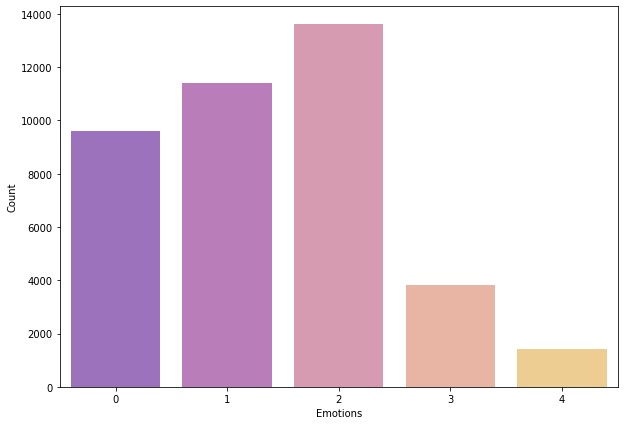

In [ ]:
data_train = pd.read_csv("merged_data.csv", sep=',', encoding='utf-8' )

count  = data_train.iloc[:,1].value_counts()

plt.figure(figsize=(10,7))
sns.barplot(count.index, count.values, alpha=0.6, palette="plasma")
plt.ylabel('Count', fontsize=10)
plt.xlabel('Emotions', fontsize=10)
plt.show()

# 0 - neutral
# 1 - happy
# 2 - sad
# 3 - love
# 4 - anger 

In [ ]:
texts, labels = [], []
with open('/content/merged_data.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        # print(row)
        texts.append(row[0])
        labels.append(row[1])
print(len(texts), len(labels))

39858 39858


In [ ]:
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
data_int = pad_sequences(sequences, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data = pad_sequences(data_int, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))

print("unique words: ", len(word_index))

unique words:  34359


In [ ]:
# convert labels into onehot vectors
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (39858, 30)
Shape of label tensor: (39858, 5)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])


In [ ]:
X_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
X_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [ ]:
embeddings_index = {}
f = open("/content/glove.twitter.27B.200d.txt", encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print("\nDone!")


Done!


In [ ]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("done!")

done!


In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix_ns], input_length=MAX_SEQUENCE_LENGTH, trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

In [ ]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)


l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

In [ ]:
model = Model(sequence_input, preds)
adadelta = tensorflow.keras.optimizers.Adadelta(lr=0.9, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy', optimizer=adadelta, metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


In [ ]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = ModelCheckpoint("checkpoint-{val_acc:.4f}.h5", monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [ ]:
model.save('BalanceNet.h5')

In [ ]:
model = keras.models.load_model("/content/BalanceNet.h5")

In [ ]:
model_log = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=100, callbacks=[tensorboard, model_checkpoints])
pd.DataFrame(model_log.history).to_csv("history-balance.csv")

Epoch 1/10
319/319 [==============================] - 109s 301ms/step - loss: 1.3775 - acc: 0.3933 - val_loss: 1.2901 - val_acc: 0.4602
Epoch 2/10
319/319 [==============================] - 91s 286ms/step - loss: 1.2598 - acc: 0.4685 - val_loss: 1.2275 - val_acc: 0.5018
Epoch 3/10
319/319 [==============================] - 90s 281ms/step - loss: 1.2217 - acc: 0.4916 - val_loss: 1.2173 - val_acc: 0.4937
Epoch 4/10
319/319 [==============================] - 90s 283ms/step - loss: 1.2015 - acc: 0.5072 - val_loss: 1.1962 - val_acc: 0.5116
Epoch 5/10
319/319 [==============================] - 91s 286ms/step - loss: 1.1883 - acc: 0.5090 - val_loss: 1.1750 - val_acc: 0.5179
Epoch 6/10
319/319 [==============================] - 90s 282ms/step - loss: 1.1778 - acc: 0.5150 - val_loss: 1.1749 - val_acc: 0.5234
Epoch 7/10
319/319 [==============================] - 90s 283ms/step - loss: 1.1700 - acc: 0.5172 - val_loss: 1.1727 - val_acc: 0.5193
Epoch 8/10
319/319 [==============================] - 

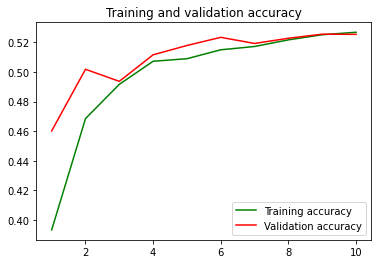

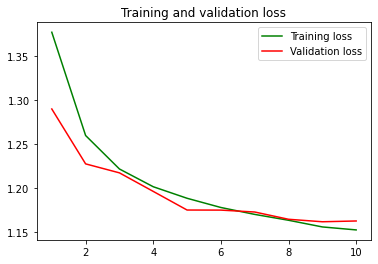

In [ ]:
import matplotlib.pyplot as plt

accuracy = model_log.history['acc']
val_accuracy = model_log.history['val_acc']
loss = model_log.history['loss']
val_loss = model_log.history['val_loss']

epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["Neutral", "Happy", "Sad", "Love", "Anger"]

In [ ]:
model_test = load_model('/content/checkpoint-0.5255.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model_test.predict(X_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [ ]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

     Neutral       0.51      0.40      0.45      1957
       Happy       0.50      0.54      0.52      2283
         Sad       0.56      0.68      0.62      2730
        Love       0.50      0.39      0.44       730
       Anger       0.33      0.10      0.15       271

    accuracy                           0.53      7971
   macro avg       0.48      0.42      0.44      7971
weighted avg       0.52      0.53      0.51      7971



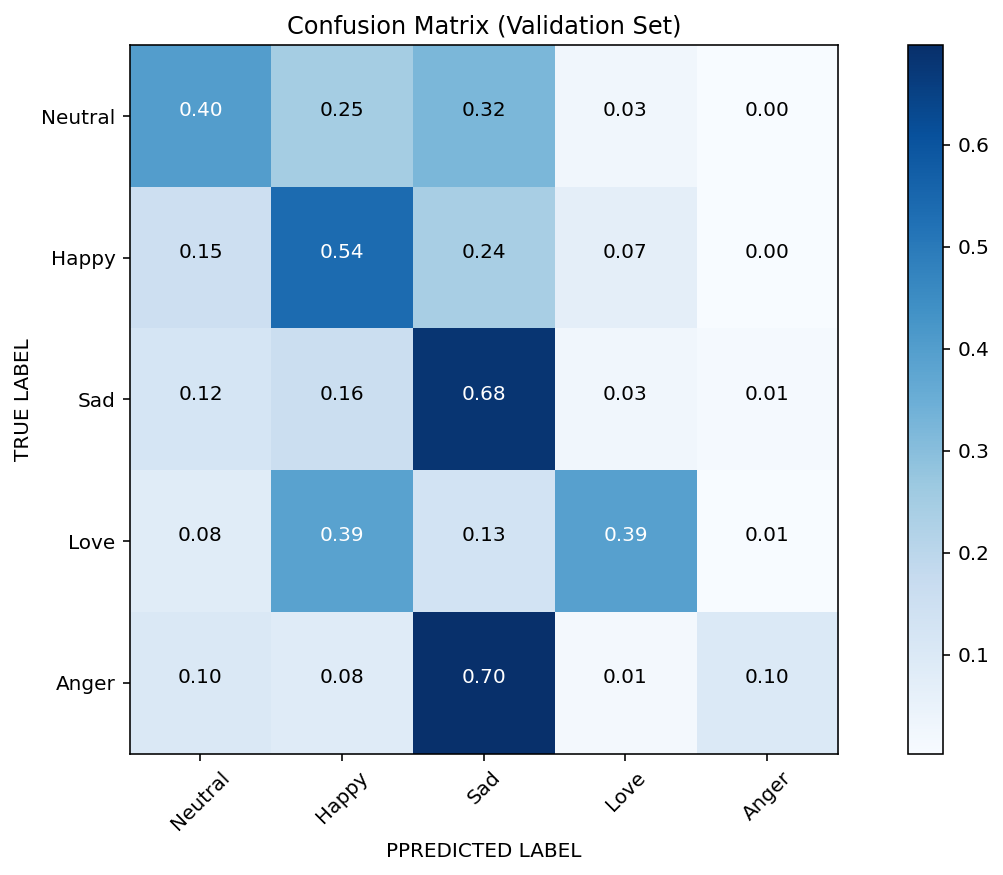

In [ ]:
def plot_confusion_matrix(cm, labels, normalize=True, title='Confusion Matrix (Validation Set)', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('TRUE LABEL')
    plt.xlabel('PPREDICTED LABEL')

plt.figure(figsize=(10,6))
plot_confusion_matrix(cnf_matrix, labels=classes)

In [ ]:
#Predicting emotions from paragraphs and sentences.

text = ["For instance, giving a kiss to your younger sibling daily after waking up in the morning and showing him how much you love them. For some happiness means loving life and seeing others happy. While some finds happiness in writing stories. Some conquer happiness in being simple yet the best person they can ever be. Everyone has their own unique way to feel happy by finding things that they never expected to find.", # happy
        "Love is the key to happiness. We all want to lead a happy life. People look around for happiness in power, fashion, wealth, drugs etc. But these things can only give temporary pleasures. The power of love can create miracles. Love can create unity among nations and its citizens. Love is the most beautiful feeling in the world. Love has given different meaning by different people depending upon how they have experienced this wonderful feeling.", # love
        "One day I was studying in my room when, all of a sudden, i heard hot words being exchanged between two persons in the street. I paid no attention, thinking it would be a minor quarrel but soon I heard the voices of a large number of people. I peeped from the window and saw that there was a street quarrel. I went downstairs and reached the spot in the twinkling of an eyes. I was at my wits end on seeing that both of them had come to blows. The people were standing around them and enjoying their quarrel but none tried to pacify them.", # sad
        "I am so angry at you!!!!!", # anger
        "you ve hit a new low with a danger of blm fascist slogan please stop it before too late stop", # anger
        "I love my doggg", # love
        "I think i'm gonna be sick :'‑(", # sad
        "I hate you so much", # anger
        "I'm at work", # neutral
        "@TheTombert i was watching Harpers Island, lol... there was no vodka involved", # neutral
        "sometimes i wish things could go back to the way they were the beginning of last summer", # sad
        "it's your 18th birthday finally!!! yippeeeee", # happy
        "still waiting in line", # neutral
        "aarrgghh - fu*k.....a hose has leaked water all over the new floating floor", # anger
        "that b*tch is so ugly", # anger
        "oh no he is hospitalised!!!", # sad
        ]

In [ ]:
sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPREDICTION:",classes[pred],"\n")

For instance, giving a kiss to your younger sibling daily after waking up in the morning and showing him how much you love them. For some happiness means loving life and seeing others happy. While some finds happiness in writing stories. Some conquer happiness in being simple yet the best person they can ever be. Everyone has their own unique way to feel happy by finding things that they never expected to find. 
PREDICTION: Happy 

Love is the key to happiness. We all want to lead a happy life. People look around for happiness in power, fashion, wealth, drugs etc. But these things can only give temporary pleasures. The power of love can create miracles. Love can create unity among nations and its citizens. Love is the most beautiful feeling in the world. Love has given different meaning by different people depending upon how they have experienced this wonderful feeling. 
PREDICTION: Love 

One day I was studying in my room when, all of a sudden, i heard hot words being exchanged betwee